# X-Ray: Pneumonia or normal clasification

## Introduction

In the field of medicine, early and accurate disease detection is of paramount importance to improve patient outcomes and provide effective treatment. Pneumonia is a serious respiratory condition that affects millions of people worldwide. The use of technology and machine learning has become a promising tool to enhance pneumonia detection through X-ray images. This report presents the results and findings of a binary classification model designed for pneumonia detection in X-ray images, with outstanding performance in recall of over 99,5%. Throughout this report, we will explore the development process of this model and its methodology.

This project will be orientated in building a classification model to detect pneumonia in x-ray images.

## Importing the libraries and setting the ramdomness seeds

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import logging
import random
import warnings
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision
from torch.utils.data import DataLoader, WeightedRandomSampler

warnings.filterwarnings('ignore')

In [65]:
seed = 42 

# Torch seed
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Numpy seed
np.random.seed(seed)

# python seed
random.seed(seed)

## Building the datasets

### Transformations to the dataset

To pre-process the data to standarize it we will be using the following parameters:

__For dataset standarization:__

    * Resize: Images of 100x100px. This has enough information to be processed in most cpu while having a good performance.
    * Grayscale: X-ray images are in grayscale, so we will be using this one channel.
    
__For dataset balance (data_augmentation):__

    * CenterCrop: Some classes of the dataset are inbalanced, so we will use CenterCrop to generate new data and balance de minority class while not altering too much the data.
    
__For dataset augmentation (data_augmentation2):__

    * RandomCrop: x-ray images can be taken with movement in any direction, so we will be using RandomCrop over all the dataset to include this movement and have better performance.

In [66]:
transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Lambda(lambda x: x / 255.0),
])

### Data splitting

We split the training dataset into train and validation dataset, while the whole test dataset will be used for testing the model.

In [67]:
batch_size = 128

train_validation_dir = "data/train"
test_dir = "data/test"

train_validation = ImageFolder(root=train_validation_dir, transform=transform)
test = ImageFolder(root=test_dir, transform=transform)

train_split = int(len(train_validation)*0.8)
validation_split = int(len(train_validation)-train_split)

train, validation = torch.utils.data.random_split(train_validation, [train_split, validation_split])

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

classes = ("NORMAL", "PNEUMONIA")

## Exploring the dataset

In [68]:
def class_count(loader: DataLoader, subset: str):
    pneumonia = 1
    normal = 0
    
    pneumonia_count = 0
    normal_count = 0
    
    for images, labels in loader:
        pneumonia_count += torch.sum(labels == pneumonia).item()
        normal_count += torch.sum(labels == normal).item()
    
    print("There are {} pneumonia images in the {} dataset".format(pneumonia_count, subset))
    print("There are {} normal images in the {} dataset".format(normal_count, subset))
    
def batch_shape(loader: DataLoader, subset: str):
    first_batch = next(iter(train_loader))
    images, labels = first_batch
    
    print("The shape of each batch in {} is: {}".format(subset, images.shape))
    return images, labels

def show_images(images: torch.Tensor, labels: torch.Tensor):
    plt.figure(figsize=(10,10))

    for i in range(8):
        plt.subplot(2,4, i+1)
        img = images[i].squeeze().numpy()
        lab = labels[i].squeeze().numpy()
        plt.imshow(img, cmap='gray')
        plt.title(classes[lab])

    plt.tight_layout(pad=0)
    plt.tight_layout(pad=0)
    plt.tight_layout(pad=0)
    plt.show()

In [69]:
from torch.utils.data import DataLoader

class_count(train_loader, "Train")
class_count(validation_loader, "Validation")
class_count(test_loader, "Test")

There are 3103 pneumonia images in the Train dataset
There are 1085 normal images in the Train dataset
There are 783 pneumonia images in the Validation dataset
There are 264 normal images in the Validation dataset
There are 406 pneumonia images in the Test dataset
There are 256 normal images in the Test dataset


In [70]:
train_images, train_labels = batch_shape(train_loader, "Train")
validation_images, validation_labels = batch_shape(validation_loader, "Validation")
test_images, test_labels = batch_shape(test_loader, "Test")

The shape of each batch in Train is: torch.Size([128, 1, 150, 150])
The shape of each batch in Validation is: torch.Size([128, 1, 150, 150])
The shape of each batch in Test is: torch.Size([128, 1, 150, 150])


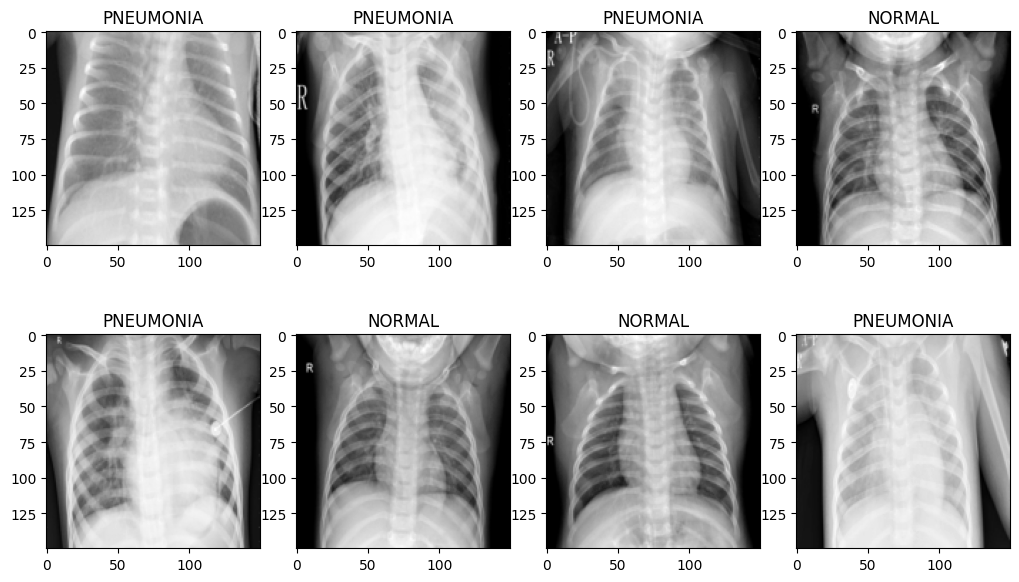

In [71]:
show_images(train_images, train_labels)

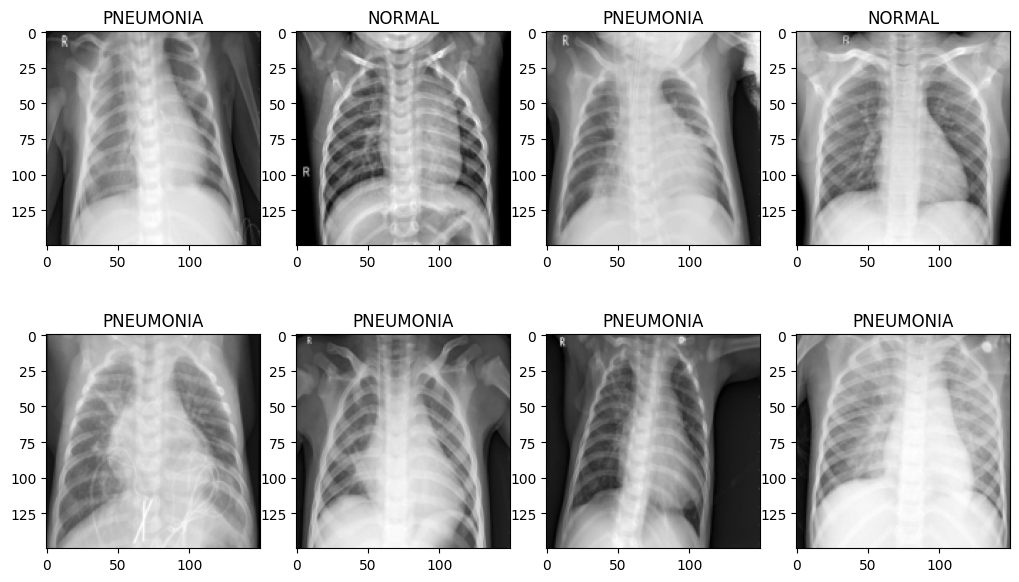

In [72]:
show_images(validation_images, validation_labels)

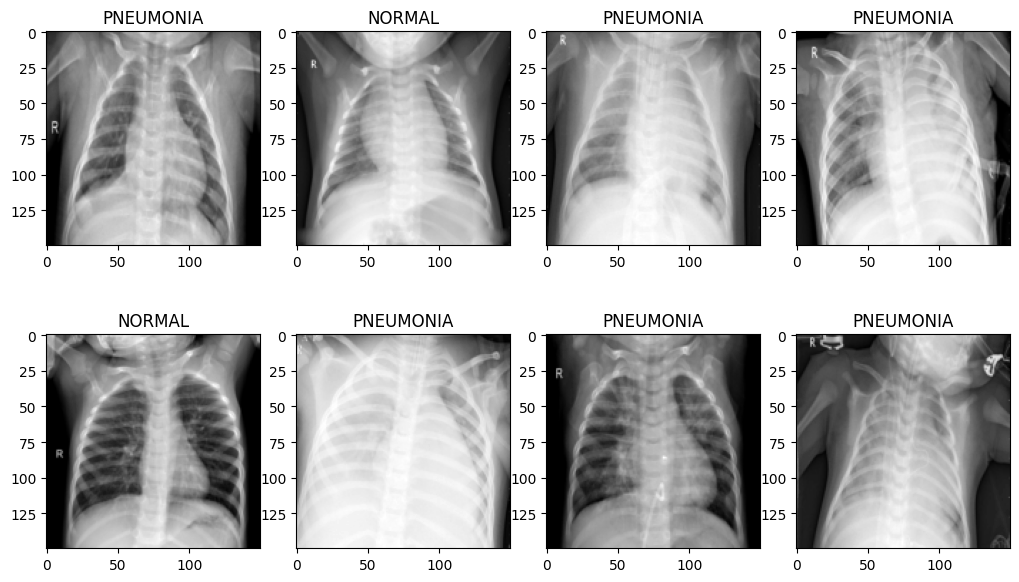

In [73]:
show_images(test_images, test_labels)

Observations:

    * All images are centered. This may not be a real case in x-ray images.
    * There is a clear minority class (Normal). We should reduce the class inbalance with augmentation.

## Model construction

We will be using a variation of the shallow network. Please see https://link.springer.com/article/10.1007/s42452-019-1903-4. The model is used in a classification problem for múltiple diseases classified from x-ray images, so it should work well with our problem.

In [84]:
## Parameters
tensor = torch.randn(train_images.shape)
channels = tensor.shape[1]
height = tensor.shape[2]
width = tensor.shape[3]
batch_size = tensor.shape[0]

In [85]:
def conv_layer(in_filters, out_filters):
    
    return nn.Sequential(
        nn.Conv2d(in_channels=in_filters, out_channels=out_filters, kernel_size=3),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(out_filters),
        nn.ReLU(),
    )
    
def dense_layer(in_filters, out_filters):
    
    return nn.Sequential(
        nn.Linear(in_features=in_filters, out_features=out_filters),
        nn.ReLU(),
    )


In [87]:
import torch.nn as nn

class ShallowNetwork(nn.Module):
    def __init__(self, channels, height, width, batch_size):
        super(ShallowNetwork, self).__init__()
        
        # Capas de convolución
        self.conv_layers = nn.Sequential(
            
            conv_layer(channels, 32),
            conv_layer(32, 32),
            conv_layer(32,64),
            conv_layer(64,64),
            conv_layer(64, 128),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            dense_layer(512, 256),
            dense_layer(256,1),
            nn.Sigmoid()
        )
        
    
    def reset_parameters(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_uniform(module.weight, a=0)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight,1)
                nn.init.constant_(module.bias, 0)

                
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [88]:
## Model Summary
model = ShallowNetwork(channels, height, width, batch_size)

In [89]:
from torchsummary import summary
summary(model, (channels, height, width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             320
         MaxPool2d-2           [-1, 32, 74, 74]               0
       BatchNorm2d-3           [-1, 32, 74, 74]              64
              ReLU-4           [-1, 32, 74, 74]               0
            Conv2d-5           [-1, 32, 72, 72]           9,248
         MaxPool2d-6           [-1, 32, 36, 36]               0
       BatchNorm2d-7           [-1, 32, 36, 36]              64
              ReLU-8           [-1, 32, 36, 36]               0
            Conv2d-9           [-1, 64, 34, 34]          18,496
        MaxPool2d-10           [-1, 64, 17, 17]               0
      BatchNorm2d-11           [-1, 64, 17, 17]             128
             ReLU-12           [-1, 64, 17, 17]               0
           Conv2d-13           [-1, 64, 15, 15]          36,928
        MaxPool2d-14             [-1, 6

## Model Training

We decided to use the following metrics to evaluate the model:

    * Recall: The primary goal is to have the minimum False Negatives in the predictions, so we will need a high Recall. This is important due to the severity in not diagnosing pneumonia to a pacient that has it.
    * F1-Score: Then we need to have a descent F1-score to make a valid model that does classify the true negatives.
    * False Positives: Then we want to see how much people we diagnosed being false negatives. We want to have the less numbers posible.
    * Loss rate: At last we want to see the loose rate of the model. 
    
We will use BCEWithLogitsLoss criterion and a optimizer Adam.
loose rate and weight decay were tested multiple times to give the best performance.

In [128]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [137]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from torch.nn.utils import clip_grad_norm_
import time

def model_eval(loader, loss_epoch):
    model.eval()
    running_loss = 0.0
    total_labels = []
    total_predictions = []
        
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            labels = labels.view(-1, 1).float()
            outputs = model(inputs)
                
            l1_reg = torch.tensor(0.0)
            for param in model.parameters():
                l1_reg += torch.norm(param, p=1)
                
            loss = criterion(outputs, labels)
            loss += l1_lambda * l1_reg
                
            running_loss += loss.item()

            predictions = (outputs > threshold).float()
            total_labels.extend(labels.cpu().numpy())
            total_predictions.extend(predictions.cpu().numpy())
    
    outputs = {"running_loss":running_loss, "total_labels":total_labels, "total_predictions":total_predictions}
    
    return outputs

def metrics(loader, total_labels, total_predictions):
    precision = precision_score(total_labels, total_predictions)
    accuracy = accuracy_score(total_labels, total_predictions)
    recall = recall_score(total_labels, total_predictions)
    f1 = f1_score(total_labels, total_predictions)
    confusion = confusion_matrix(total_labels, total_predictions)
    
    metrics = {"precision":precision, "accuracy":accuracy, "recall":recall, "f1":f1, "confusion":confusion}
    
    return(metrics)


def model_train(pos_weight:float, lr:float, l1_lambda:float, criterion, optimizer, num_epochs:int, model:ShallowNetwork, threshold:float):
    
    train_loss_epoch = []
    train_precision_epoch = []
    train_recall_epoch = []
    train_accuracy_epoch = []
    train_f1_epoch = []
    
    val_loss_epoch = []
    val_precision_epoch = []
    val_recall_epoch = []
    val_accuracy_epoch = []
    val_f1_epoch = []

    for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0
        total_train_labels = []
        total_train_predictions = []

        for i, data in enumerate(train_loader, 0):
            train_inputs, train_labels = data
            train_labels = train_labels.view(-1, 1)
            train_labels = train_labels.float()

            l1_reg_train = torch.tensor(0.0)
            
            for param in model.parameters():
                l1_reg_train += torch.norm(param, p=1)

            optimizer.zero_grad()
            outputs = model(train_inputs)
            
            train_loss = criterion(outputs, train_labels)
            train_loss += l1_lambda * l1_reg_train
            train_loss.backward()

            clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            running_loss += train_loss.item()

            train_predictions = (outputs > threshold).float()

            total_train_labels.extend(train_labels.cpu().numpy())
            total_train_predictions.extend(train_predictions.cpu().numpy())
        
        val_outputs = model_eval(validation_loader, val_loss_epoch)
        
        val_metrics = metrics(validation_loader, val_outputs['total_labels'], val_outputs['total_predictions'])
        train_metrics = metrics(train_loader, total_train_labels, total_train_predictions)
        
        val_loss_epoch.append(val_outputs["running_loss"]/len(validation_loader))
        val_precision_epoch.append(val_metrics["precision"])
        val_recall_epoch.append(val_metrics["recall"])
        val_accuracy_epoch.append(val_metrics["accuracy"])
        val_f1_epoch.append(val_metrics["f1"])
        
        train_loss_epoch.append(running_loss/len(train_loader))
        train_precision_epoch.append(train_metrics["precision"])
        train_recall_epoch.append(train_metrics["recall"])
        train_accuracy_epoch.append(train_metrics["accuracy"])
        train_f1_epoch.append(train_metrics["f1"])

        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}")
        print(f"Loss: {running_loss/len(train_loader)}, Precision: {train_metrics['precision']}, Recall: {train_metrics['recall']}, F1-Score: {train_metrics['f1']}")
        print(f"Loss: {val_outputs['running_loss']/len(validation_loader)}. Precision: {val_metrics['precision']}, Recall: {val_metrics['recall']}, F1-Score: {val_metrics['f1']}")
        print(f"Training Confusion Matrix:\n{train_metrics['confusion']}")
        print(f"Validation Confusion Matrix:\n{val_metrics['confusion']}")
        print("-----------------------------------------------------------------------------------------------------------------------------")

    
    model.train()
    PATH = './x_ray_net.pth'
    torch.save(model, PATH)

    print("Finished Training")
    
    return {
        'Train Loss': train_loss_epoch,
        'Train Precision': train_precision_epoch,
        'Train Accuracy': train_accuracy_epoch,
        'Train Recall': train_recall_epoch,
        'Train F1 Score': train_f1_epoch,
        'Train confusion matrix' : train_metrics["confusion"],
        
        'Val Loss': val_loss_epoch,
        'Val Precision' : val_precision_epoch,
        'Val Accuracy' : val_accuracy_epoch,
        'Val Recall' : val_recall_epoch,
        'Val F1 Score': val_f1_epoch,
        'Val confusion matrix' : val_metrics["confusion"]
    }

## Model Training

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metrics(num_epochs, train_iter):
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))

    axes[0,0].set_title("Training Loss")
    axes[0,0].set_xlabel("Epoch")
    axes[0,0].set_ylabel("Loss")
    sns.lineplot(x=range(1, num_epochs+1), y=np.sqrt(train_iter["Train Loss"]), label="Train Loss", ax=axes[0,0])
    sns.lineplot(x=range(1, num_epochs+1), y=np.sqrt(train_iter["Val Loss"]), label="Validation Loss", ax=axes[0,0])

    axes[0,1].set_title("Training Accuracy")
    axes[0,1].set_xlabel("Epoch")
    axes[0,1].set_ylabel("Accuracy")
    sns.lineplot(x=range(1, num_epochs+1), y=np.sqrt(train_iter["Train Accuracy"]), label="Train Accuracy", ax=axes[0,1])
    sns.lineplot(x=range(1, num_epochs+1), y=np.sqrt(train_iter["Val Accuracy"]), label="Validation Accuracy", ax=axes[0,1])

    axes[1,0].set_title("Training Recall")
    axes[1,0].set_xlabel("Epoch")
    axes[1,0].set_ylabel("Recall")
    sns.lineplot(x=range(1, num_epochs+1), y=np.sqrt(train_iter["Train Recall"]), label="Train Recall", ax=axes[1,0])
    sns.lineplot(x=range(1, num_epochs+1), y=np.sqrt(train_iter["Val Recall"]), label="Validation Recall", ax=axes[1,0])

    axes[1,1].set_title("Training F1 Score")
    axes[1,1].set_xlabel("Epoch")
    axes[1,1].set_ylabel("F1 Score")
    sns.lineplot(x=range(1, num_epochs+1), y=np.sqrt(train_iter["Train F1 Score"]), label="Train F1 Score", ax=axes[1,1])
    sns.lineplot(x=range(1, num_epochs+1), y=np.sqrt(train_iter["Val F1 Score"]), label="Validation F1 Score", ax=axes[1,1])

    plt.tight_layout()
    plt.show()

In [118]:
## Hyperparameters
import torch.optim as optim

pos_weight = torch.tensor([0.33])
lr = 0.0005
l1_lambda= 0.0001
threshold = 0.5

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l1_lambda)

num_epochs = 50

In [119]:
model.reset_parameters()
model_train = model_train(pos_weight, lr, l1_lambda, criterion, optimizer, num_epochs, model, threshold)

Epoch 1/50, Batch 33/33
Loss: 1.7425644433859624, Precision: 0.6451612903225806, Recall: 0.006445375443119562, F1-Score: 0.012763241863433314
Loss: 1.5593741999732122. Precision: 0.0, Recall: 0.0, F1-Score: 0.0
Training Confusion Matrix:
[[1074   11]
 [3083   20]]
Validation Confusion Matrix:
[[264   0]
 [783   0]]
-----------------------------------------------------------------------------------------------------------------------------
Epoch 2/50, Batch 33/33
Loss: 1.4192701289148042, Precision: 1.0, Recall: 0.0016113438607798904, F1-Score: 0.0032175032175032173
Loss: 1.2556620438893635. Precision: 1.0, Recall: 0.007662835249042145, F1-Score: 0.01520912547528517
Training Confusion Matrix:
[[1085    0]
 [3098    5]]
Validation Confusion Matrix:
[[264   0]
 [777   6]]
-----------------------------------------------------------------------------------------------------------------------------
Epoch 3/50, Batch 33/33
Loss: 1.1202897212722085, Precision: 0.9562700964630225, Recall: 0.479

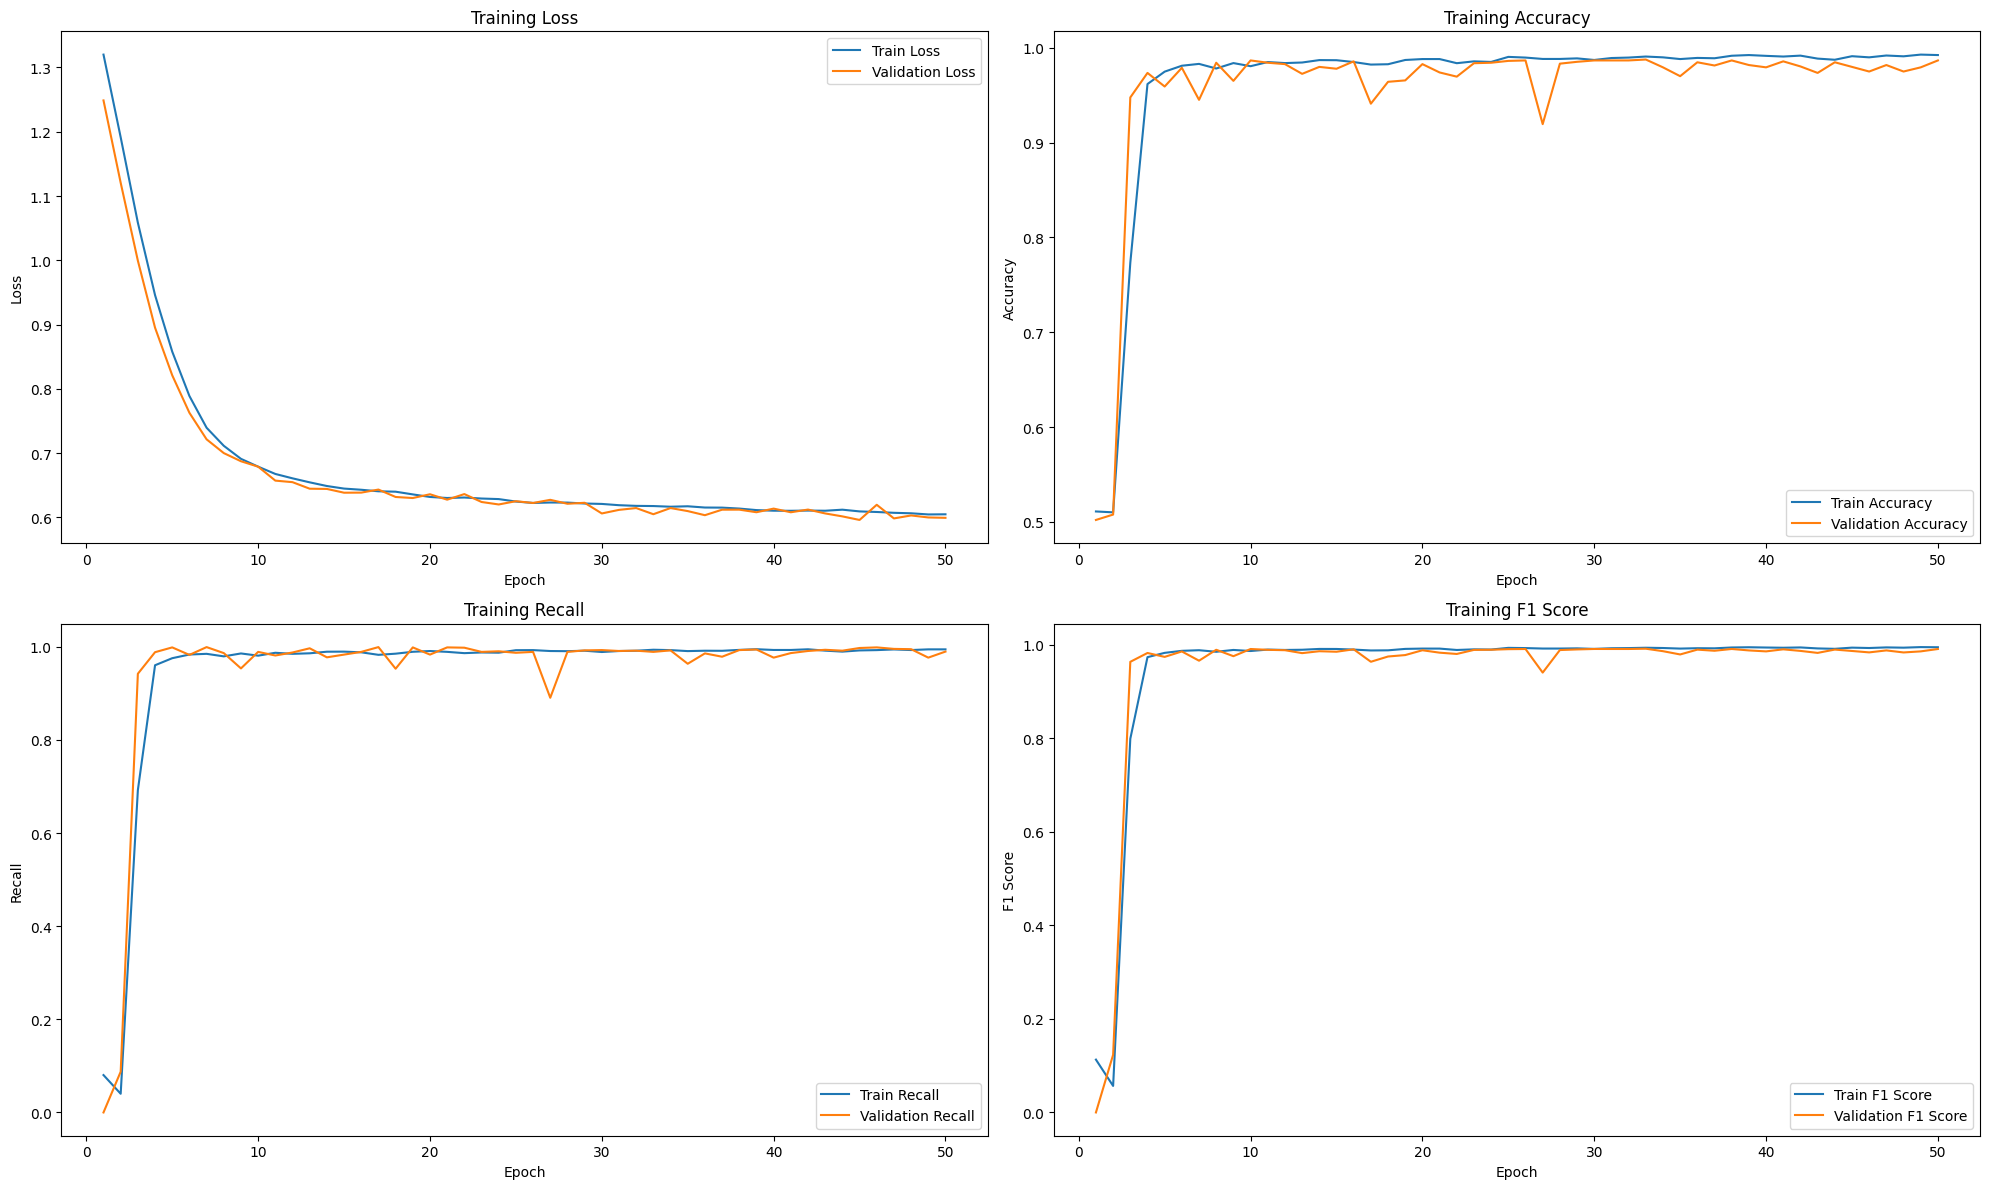

In [120]:
plot_metrics(num_epochs, model_train)

## Testing the model

Kaggle provides a test dataset which we can use to test the model, which we will use to get some results.

In [139]:
model = torch.load("./x_ray_net.pth")
model.eval()
running_test_loss = 0
total_test_labels = []
total_test_predictions = []

with torch.no_grad():
    for test_data in test_loader:
        test_inputs, test_labels = test_data
        test_labels = test_labels.view(-1, 1).float()
        test_outputs = model(test_inputs)
                
        l1_reg_test = torch.tensor(0.0)
        for param in model.parameters():
            l1_reg_test += torch.norm(param, p=1)
                
        test_loss = criterion(test_outputs, test_labels)
        test_loss += l1_lambda * l1_reg_test
                
        running_test_loss += test_loss.item()

        test_predictions = (test_outputs > threshold).float()
        total_test_labels.extend(test_labels.cpu().numpy())
        total_test_predictions.extend(test_predictions.cpu().numpy())
        
confusion = confusion_matrix(total_test_labels, total_test_predictions)

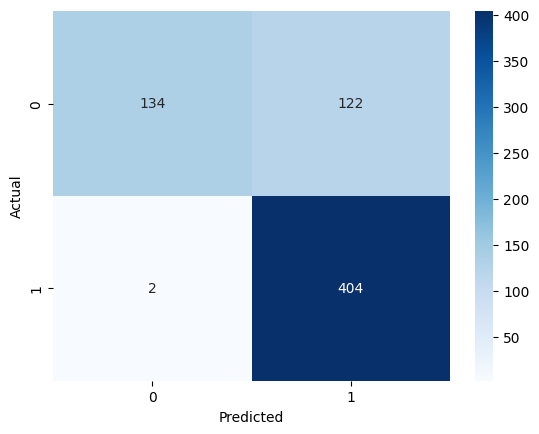

In [140]:
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [142]:
print('Scores for the model:')
print(f'Recall score: {recall_score(total_test_labels, total_test_predictions)}')
print(f'Accuracy score: {accuracy_score(total_test_labels, total_test_predictions)}')
print(f'f1-score: {f1_score(total_test_labels, total_test_predictions)}')

Scores for the model:
Recall score: 0.9950738916256158
Accuracy score: 0.8126888217522659
f1-score: 0.8669527896995708


As we can see, we have only 2 false negative values, resulting in a recall score of 99.5%, which is excellent. However, the accuracy score is 81%, and the F1 score is 86.7%. This discrepancy could be due to misclassifications in the test data or cases where the model identifies other diseases as pneumonia. Obtaining a radiologist's opinion may help identify and rectify any issues. In the meantime, we can conclude that the model effectively detects positive cases, which was our initial goal.

## Conclusion

In summary, the binary classification model developed for pneumonia detection in X-ray images has proven to be a highly effective tool in medical practice, boasting an impressive recall of 99.5%. This high recall demonstrates the model's ability to reliably identify pneumonia cases in X-ray images, thus contributing to quicker and more precise disease detection.

However, it's crucial to acknowledge a significant limitation of this study—the dataset exclusively comprises pneumonia cases. In real-world scenarios, various other respiratory diseases may exist, and the model's performance in detecting these conditions remains untested, likely contributing to the lower accuracy and F1-score. Therefore, further research and data collection are essential to expand the model's applicability and ensure its effectiveness in a broader range of clinical situations.

These results indicate that machine learning techniques in medical image analysis have the potential to revolutionize clinical practice by enhancing efficiency and diagnostic accuracy. Nonetheless, it's important to emphasize that this model should serve as a supportive tool for healthcare professionals. Clinical decision-making should still rely on a comprehensive evaluation that incorporates multiple sources of information.